In [1]:
import pandas as pd
import numpy as np
# allow multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load Treated dataset from EDA

In [2]:
df = pd.read_csv("ad_clicks_100k_Treated.csv")
df.drop(columns="Unnamed: 0", inplace=True)
df.head()
df.shape

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day,weekday
0,6.448465e+18,0,2014-10-28 06:00:00,1005,0,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,...,320,50,2227,0,935,-1,48,6,28,Tuesday
1,1.342805e+19,0,2014-10-23 07:00:00,1002,0,85f751fd,c4e18dd6,50e219e0,9a08a110,7801e8d9,...,320,50,2495,2,167,-1,23,7,23,Thursday
2,1.048699e+19,0,2014-10-23 10:00:00,1005,0,9a28a858,64778742,f028772b,ecad2386,7801e8d9,...,300,250,2523,3,39,-1,221,10,23,Thursday
3,8.833733e+18,0,2014-10-23 07:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,7,23,Thursday
4,1.035453e+19,0,2014-10-28 11:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,...,320,50,2676,0,35,100176,221,11,28,Tuesday


(100000, 27)

### Drop features that will not go into the model
- `id` (We do not need the variable ID as predictor, it does not make sense to use)
- `hour` (because hour was broken down into (day, weekday, hour_of_day)) 
- `day` (because we find that it will add no significant predictive value that makes sense in any future application, i.e. the dataset covers 10 days of the year and we have no way to know if any of those days is representative of the year, or if there was something exceptional happening. By using `hour_of_day` and `weekday` we average these values and thus make this possible effect less significant)   
- `device_ip` and `device_id`

Given `device_id` and `device_ip` are uniquely identifing the specific `device` and public `id` adress (which is not immutable for the same person - i.e. you can sport different public ips at different times) of the person that clicked the ad, these provide no meaningfull or usefull information toward predictic `clicks`. 

There is actually a problem of, given that these are very high cardinality features, them playing a very "important" yet misleading role when models are applied to the dataset. Furthermore, these features represent a person that may never be seen again by the model in when applied in reality or with a different dataset therefore it would be wrong to include these in the modeling process. 

We are interested in knowing what are the shared characteristics of anyone that clicks, and the above mentioned features do not fit this requirement.

In [3]:
print(f'Shape after EDA ---->> {df.shape}')
df.drop(columns=['id','hour','device_ip','device_id','day'], inplace=True)
df.head()
print(f'Shape after feature drop ---->> {df.shape}')

Shape after EDA ---->> (100000, 27)


,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,weekday
0,0,1005,0,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,07d7df22,9efa421a,...,19771,320,50,2227,0,935,-1,48,6,Tuesday
1,0,1002,0,85f751fd,c4e18dd6,50e219e0,9a08a110,7801e8d9,07d7df22,02d14ecc,...,21676,320,50,2495,2,167,-1,23,7,Thursday
2,0,1005,0,9a28a858,64778742,f028772b,ecad2386,7801e8d9,07d7df22,ecb851b2,...,21837,300,250,2523,3,39,-1,221,10,Thursday
3,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,779d90c2,...,15706,320,50,1722,0,35,-1,79,7,Thursday
4,0,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,dc15c87e,...,23224,320,50,2676,0,35,100176,221,11,Tuesday


Shape after feature drop ---->> (100000, 22)


## Pre-processing:
- One Hot encoding for low cardinality features (1 to 7 unique categories)
    - In this way we will still one-hot-encode `weekday` for which we have a clear interpretation of what each of its separate values means
- Label encoding for medium cardinality features (7 to 100 unique categories)
- Target encoding for high cardinality features (100+ unique categories)
    - (Since it has to be done within Cross Validation we will filter and add to a list the features we consider to have high cardinality)

- Numerical Features: `hour_of_day` will not be encoded (it already is a discrete variable)

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

In [5]:
# Split into features type "O" and already encoded features
categorical_columns = [i for i in list(df.columns) if df[i].dtypes in ["O"] and i not in ['id','hour','hour_of_day','click']]
encoded_categorical_columns = [i for i in list(df.columns) if df[i].dtypes not in ["O"] and i not in ['id','hour','hour_of_day','click']]
print(f'Features with dtype "O" {categorical_columns}')
print(f'Categorical Features (already with discrete values) {encoded_categorical_columns}')


Features with dtype "O" ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_model', 'weekday']
Categorical Features (already with discrete values) ['C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


In [6]:
# Transform features type "O" with label encoder
for i in categorical_columns:
    if i == 'weekday':
        # Ordinal Encode Weekday
        categories = [['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
        #Instantiate ordinal encoder
        ordinal_encoder = OrdinalEncoder(categories=categories)
        #Fit ordinal encoder
        ordinal_encoder.fit(df[['weekday']])
        # transform the data
        df['weekday'] = ordinal_encoder.transform(df[['weekday']])
    label_encoder = []
    le = LabelEncoder()
    le.fit(df[i])    
    label_encoder.append(le)
    df[i] = le.transform(df[i])

all_features = categorical_columns + encoded_categorical_columns
print(all_features)

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

OrdinalEncoder(categories=[['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                            'Friday', 'Saturday', 'Sunday']])

LabelEncoder()

['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_model', 'weekday', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


## Apply 

In [7]:
data = df.copy()
one_hot = []
label_enc = []
target_enc = []
for i in all_features:
    if len(df[i].unique()) <= 7:
        # One hot encoding
        one_hot.append(i)
        data = pd.concat([data, pd.get_dummies(df[i], prefix=i)],axis=1)
        # Drop the original column
        data.drop(columns=[i], inplace=True)
    elif 100 >= len(df[i].unique()) > 7:
        # Label encoding
        label_enc.append(i)
    elif len(df[i].unique()) > 100:
        # Mean encoding
        target_enc.append(i)

print('Previus Dataset Shape ->> ', df.shape)
print('Shape After Encoding  ->> ', data.shape, '\n')
print(f'One Hot Encoding the following features: {one_hot}')
print(f'Label Encoding the following features: {label_enc}')
print(f'Selected for Target Encoding: {target_enc}')
data.head()

Previus Dataset Shape ->>  (100000, 22)
Shape After Encoding  ->>  (100000, 49) 

One Hot Encoding the following features: ['weekday', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C18']
Label Encoding the following features: ['site_category', 'app_domain', 'app_category', 'C15', 'C16', 'C19', 'C21']
Selected for Target Encoding: ['site_id', 'site_domain', 'app_id', 'device_model', 'C14', 'C17', 'C20']


,click,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,C14,C15,...,device_type_4,device_type_5,device_conn_type_0,device_conn_type_2,device_conn_type_3,device_conn_type_5,C18_0,C18_1,C18_2,C18_3
0,0,1215,998,17,1195,41,0,1956,19771,320,...,0,0,1,0,0,0,1,0,0,0
1,0,770,1043,5,783,41,0,36,21676,320,...,0,0,1,0,0,0,0,0,1,0
2,0,890,535,17,1195,41,0,2936,21837,300,...,0,0,1,0,0,0,0,0,0,1
3,0,167,1261,1,1195,41,0,1476,15706,320,...,0,0,1,0,0,0,1,0,0,0
4,0,770,1043,5,842,67,3,2746,23224,320,...,0,0,0,1,0,0,1,0,0,0


In [8]:
data.columns

Index(['click', 'site_id', 'site_domain', 'site_category', 'app_id',
       'app_domain', 'app_category', 'device_model', 'C14', 'C15', 'C16',
       'C17', 'C19', 'C20', 'C21', 'hour_of_day', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'C1_1001', 'C1_1002', 'C1_1005', 'C1_1007', 'C1_1008', 'C1_1010',
       'C1_1012', 'banner_pos_0', 'banner_pos_1', 'banner_pos_2',
       'banner_pos_3', 'banner_pos_4', 'banner_pos_5', 'banner_pos_7',
       'device_type_0', 'device_type_1', 'device_type_4', 'device_type_5',
       'device_conn_type_0', 'device_conn_type_2', 'device_conn_type_3',
       'device_conn_type_5', 'C18_0', 'C18_1', 'C18_2', 'C18_3'],
      dtype='object')

## Split the Dataset

In [9]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['click'])
y = data['click']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(80000, 48)

(80000,)

(20000, 48)

(20000,)

## Lets take a closer look at the high cardinality features
## Effect of implementing Target Encoding 
- Just an example of how the transformation would affect high cardinality features
- The idea behind target encoding is to reduce the effect high cardinality, some common problems from high cardinality can be:
  - Missing (NA) or invalid categorical level values
  - Novel levels encountered in model validation/testing sets
  - Extremely rare or infrequent categorical levels  

In [10]:
# Effect of Target encoding for train set
pd.options.mode.chained_assignment = None  # default='warn
X_train_encoding_example = X_train.copy()
for i in target_enc:
    data_train = pd.concat([X_train_encoding_example, y_train], axis=1)
    target_encoder = data_train.groupby([i])["click"].mean()
    X_train_encoding_example[i] = X_train_encoding_example[i].map(target_encoder)
    # Transform the test set based on the train
pd.options.mode.chained_assignment = 'warn'  # default='warn

print('------- Mean Encoding changes -------')
for i,v in enumerate(target_enc):
    print(f'{v} now would have {[len(X_train_encoding_example[i].unique()) for i in target_enc][i]} categories vs {len(X_train[v].unique())} before')

------- Mean Encoding changes -------
site_id now would have 186 categories vs 1342 before
site_domain now would have 155 categories vs 1219 before
app_id now would have 120 categories vs 1174 before
device_model now would have 350 categories vs 2939 before
C14 now would have 357 categories vs 1661 before
C17 now would have 239 categories vs 394 before
C20 now would have 103 categories vs 154 before


In [11]:
print("""Check if the example transformation above changed X_train in any way: 
How many unique X_train.device_model categories? """, len(X_train.device_model.unique()))
if len(X_train.device_model.unique()) > len(X_train_encoding_example.device_model.unique()):
    print("------>>> There was no change in the X_train set")
else: 
    print("------>>> WARNING: THERE IS DATA LEAKAGE")

Check if the example transformation above changed X_train in any way: 
How many unique X_train.device_model categories?  2939
------>>> There was no change in the X_train set


# Modeling

In [12]:
# Imports
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from category_encoders.target_encoder import TargetEncoder

from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, plot_roc_curve
from sklearn.model_selection import LeaveOneOut

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Ensemble methods
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Boosting 
from catboost import CatBoostClassifier

# Stats (util)
from scipy.stats import randint as sp_randInt
from scipy.stats import uniform as sp_randFloat

## Choosing an Evaluation Metric - F1_score

We chose to maximize the `f1-score` since this is the harmonic mean between precision and recall, given that the business problem we are addressing relies on good recall and precision of the "click" variable as it is our interest to be able to predict if a given user will click or not on the ad. 

<a><img src="https://i.ibb.co/8N3gqDv/Capturar.png" alt="Capturar" border="0"></a>

Maximizing recall only would lead to a model that ended up recalling only "click = 0" and leaving "click = 1" our main interest to predict, with a very low recall. While maximizing precision will leave us with a high number of False Positives which we would like to avoid given that a too positive outlook on the impact of marketing can backfire into lower than expected revenues given the lower than predicted interaction.

We are still interested in a balance because, even though we want to predict `click`, it still is very important to understand clearly what leads a user not to click an ad as it can lead us to identify and shif away from harmfull practices.

`AUC` is also a widely used metric to compary binary classification models, however the `AUC` is not a good measure for Imbalanced Datasets (at it is the case) because it considers only True Positive Rate against False Positive Rate, which ignores the number of actual TP and FP. That is, we may have a model with a high AUC but recalling very few True Positives. The AUC is high only because there are very few predictions for the True Positive Class and these are mostly correct.

## Modeling Pipeline
Given our dataset is unbalanced, and after preliminary modeling showed that without rebalancing the model performance was severely hidered with an over importance of the majority class. These models yielded no information, therefore we opted to use rebalancing methods.

For all models we also used a StandardScalar to control for arbitrary differences in the scales of the features, and we also performed Target Encoding, as explained above - [Effect of implementing Target Encoding](#Effect-of-implementing-Target-Encoding) - to reduce the effect of high cardinality features. This process cannot be conducted on the whole training set before Cross Validation otherwise there will we data leakage as the model would already have a feature perfectly mapping the target.

### `Pipeline` 
>_**'sampling'**_    &rarr; `RandomOverSampler()` , `RandomOverSampler()` , `SMOTE()`<br>
>_**'transformer'**_ &rarr; `TargetEncoder(cols=target_enc)`<br>
>_**'scaler'**_      &rarr; `StandardScaler()`<br>
>_**'classifier'**_  &rarr; `KNeighborsClassifier()` , `RandomForestClassifier()` , `CatBoostClassifier()` 



## KNN Classifier

`n_neighbors` represents the number of neighbors to use for kneighbors queries

`weights`: 
> `uniform` : uniform weights. All points in each neighborhood are weighted equally.<br>
> `distance` : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

In [13]:
pipe = Pipeline([('sampling', RandomOverSampler(random_state=42)), 
                 ('transformer', TargetEncoder(cols=target_enc)),
                 ('scaler', StandardScaler()), 
                 ('classifier', KNeighborsClassifier())])
param_grid = [
    {'classifier': [KNeighborsClassifier()], 
     'scaler': [StandardScaler()],
     'transformer': [TargetEncoder(cols=target_enc)],
     'sampling': [RandomUnderSampler(random_state=42), RandomOverSampler(random_state=42), SMOTE(random_state=42)],
     'classifier__n_neighbors': [3, 5, 7, 9],
     'classifier__weights': ['uniform', 'distance']}, 
]
knn_grid = GridSearchCV(pipe, param_grid, cv=10, scoring = 'f1')
knn_grid.fit(X_train, y_train)
knn_model = knn_grid.best_estimator_
print("Best cross-validation score: {:.2f}".format(knn_grid.best_score_))
print("Best params:\n{}\n".format(knn_grid.best_params_))

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sampling',
                                        RandomOverSampler(random_state=42)),
                                       ('transformer',
                                        TargetEncoder(cols=['site_id',
                                                            'site_domain',
                                                            'app_id',
                                                            'device_model',
                                                            'C14', 'C17',
                                                            'C20'])),
                                       ('scaler', StandardScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid=[{'classifier': [KNeighborsClassifier(n_neighbors=9)],
                          'classifier__n_neighbors': [3, 5, 7, 9],
                          'classifier__weights': ['uniform', 'di

Best cross-validation score: 0.37
Best params:
{'classifier': KNeighborsClassifier(n_neighbors=9), 'classifier__n_neighbors': 9, 'classifier__weights': 'uniform', 'sampling': RandomUnderSampler(random_state=42), 'scaler': StandardScaler(), 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                    'C17', 'C20'])}



### KNN - Further Narrowing the Hyper-parameter Search
We found that the number of neighbors was at the upper level of the defined interval. Thus, we decided to test if, kepping all else equal - i.e. the previously found hyper-parameters - the model's performance would increase if we increased the range of `n_neighbors`

In [32]:
pipe = Pipeline([('sampling', RandomOverSampler(random_state=42)), 
                 ('transformer', TargetEncoder(cols=target_enc)),
                 ('scaler', StandardScaler()), 
                 ('classifier', KNeighborsClassifier())])
param_grid = [
    {'classifier': [KNeighborsClassifier()], 
     'scaler': [StandardScaler()],
     'transformer': [TargetEncoder(cols=target_enc)],
     'sampling': [RandomUnderSampler(random_state=42)],
     'classifier__n_neighbors': [i for i in range(7, 52, 2)],
     'classifier__weights': ['uniform']}, 
]
knn_rand = RandomizedSearchCV(pipe, param_grid, cv=10, n_iter=10, scoring = 'f1')
knn_rand.fit(X_train, y_train)
knn_new_neigh_model = knn_rand.best_estimator_
print("Best cross-validation score: {:.2f}".format(knn_rand.best_score_))
print("Best params:\n{}\n".format(knn_rand.best_params_))

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('sampling',
                                              RandomOverSampler(random_state=42)),
                                             ('transformer',
                                              TargetEncoder(cols=['site_id',
                                                                  'site_domain',
                                                                  'app_id',
                                                                  'device_model',
                                                                  'C14', 'C17',
                                                                  'C20'])),
                                             ('scaler', StandardScaler()),
                                             ('classifier',
                                              KNeighborsClassifier())]),
                   param_distributions=[{'classifier': [KNeighborsClassifier(n_neighbors=43)

Best cross-validation score: 0.39
Best params:
{'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                    'C17', 'C20']), 'scaler': StandardScaler(), 'sampling': RandomUnderSampler(random_state=42), 'classifier__weights': 'uniform', 'classifier__n_neighbors': 43, 'classifier': KNeighborsClassifier(n_neighbors=43)}



In [101]:
print('Knn -->> {:0.5f}'.format(knn_grid.best_score_))
print('Knn Opt -->> {:0.5f}'.format(knn_rand.best_score_))

Knn -->> 0.37069
Knn Opt -->> 0.38588


# RANDOM FOREST

## Simple Random Forest

In [29]:
pipe = Pipeline([('sampling', RandomOverSampler(random_state=42)), 
                 ('transformer', TargetEncoder(cols=target_enc)),
                 ('scaler', StandardScaler()), 
                 ('classifier', RandomForestClassifier(random_state=42))])
param_grid = [
    {'classifier': [RandomForestClassifier(random_state=42)], 
     'scaler': [StandardScaler()],
     'transformer': [TargetEncoder(cols=target_enc)],
     'sampling': [None, RandomUnderSampler(random_state=42), RandomOverSampler(random_state=42), SMOTE(random_state=42)]}
]
rfc_simple_grid = GridSearchCV(pipe, param_grid, cv=10, scoring = 'f1')
rfc_simple_grid.fit(X_train, y_train)
rfc_model = rfc_simple_grid.best_estimator_
print("Best cross-validation score: {:.2f}".format(rfc_simple_grid.best_score_))
print("Best params:\n{}\n".format(rfc_simple_grid.best_params_))

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sampling',
                                        RandomOverSampler(random_state=42)),
                                       ('transformer',
                                        TargetEncoder(cols=['site_id',
                                                            'site_domain',
                                                            'app_id',
                                                            'device_model',
                                                            'C14', 'C17',
                                                            'C20'])),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid=[{'classifier': [RandomForestClassifier(random_state=42)],
                          'sampling': [None,
                         

Best cross-validation score: 0.37
Best params:
{'classifier': RandomForestClassifier(random_state=42), 'sampling': RandomUnderSampler(random_state=42), 'scaler': StandardScaler(), 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                    'C17', 'C20'])}



Even with the default parameters, `Random Forest Classifier` has a good `f1-score` performance, the same as the first optimization of the `Knn Classifer`. We will now perform some hyper-parameter tunning to try and increase the model's performace.

## Hyper-parameter Tunning of Random Forest

`min_samples_leaf` The minimum number of samples required to be at a leaf node. A smaller leaf makes the model more prone to capturing noise in train data. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs, the base of the tree.

`min_samples_split` Represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, each tree in the forest becomes more constrained as it has to consider more samples at each node.

In [17]:
pipe = Pipeline([('sampling', RandomOverSampler(random_state=42)), 
                 ('transformer', TargetEncoder(cols=target_enc)),
                 ('scaler', StandardScaler()), 
                 ('classifier', RandomForestClassifier(random_state=42))])
param_grid = [
    {'classifier': [RandomForestClassifier(random_state=42)], 
     'scaler': [StandardScaler()],
     'transformer': [TargetEncoder(cols=target_enc)],
     'sampling': [RandomUnderSampler(random_state=42), RandomOverSampler(random_state=42), SMOTE(random_state=42)],
     'classifier__n_estimators': sp_randInt(100, 1000),
     'classifier__max_depth': sp_randInt(1, 50),
     'classifier__min_samples_split': sp_randInt(1, 50),
     'classifier__min_samples_leaf': sp_randInt(1, 50)}, 
]
rfc_rand = RandomizedSearchCV(pipe, param_grid, cv=10, scoring = 'f1', n_iter=5, random_state=42)
rfc_rand.fit(X_train, y_train)
rfc_model_opt = rfc_rand.best_estimator_
print("Best cross-validation score: {:.2f}".format(rfc_rand.best_score_))
print("Best params:\n{}\n".format(rfc_rand.best_params_))

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('sampling',
                                              RandomOverSampler(random_state=42)),
                                             ('transformer',
                                              TargetEncoder(cols=['site_id',
                                                                  'site_domain',
                                                                  'app_id',
                                                                  'device_model',
                                                                  'C14', 'C17',
                                                                  'C20'])),
                                             ('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=5,
                   param_distributions=[{'clas

Best cross-validation score: 0.40
Best params:
{'classifier': RandomForestClassifier(max_depth=39, min_samples_leaf=29, min_samples_split=15,
                       n_estimators=206, random_state=42), 'classifier__max_depth': 39, 'classifier__min_samples_leaf': 29, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 206, 'sampling': RandomUnderSampler(random_state=42), 'scaler': StandardScaler(), 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                    'C17', 'C20'])}



### Random Forest - Further Narrowing the hyper-parameter search
Keeping the several types of sampling - `RandomOverSampler()` , `RandomOverSampler()` , `SMOTE()` - is computationally costly. To further explore the configuration of hyper-parameter we fixed the *sampling* method at the `RandomOverSampler()` the chosen method for the optimized `RandomForestClassifier` above and performed another `RandomizedSearchCV` with an increase number of iterations and smaller number of cross-validation folds, to increase speed of processing, focusing the tunning parameters intervals based on the above results, i.e. `n_estimators` reduce interval, `max_depth` & `min_samples_split` & `min_samples_leaf` increase bottom and upper bound.

In [34]:
pipe = Pipeline([('sampling', RandomOverSampler(random_state=42)), 
                 ('transformer', TargetEncoder(cols=target_enc)),
                 ('scaler', StandardScaler()), 
                 ('classifier', RandomForestClassifier(random_state=42))])
param_grid = [
    {'classifier': [RandomForestClassifier(random_state=42)], 
     'scaler': [StandardScaler()],
     'transformer': [TargetEncoder(cols=target_enc)],
     'sampling': [RandomUnderSampler(random_state=42)],# RandomOverSampler(random_state=42), SMOTE(random_state=42)],
     'classifier__n_estimators': sp_randInt(150, 1000),
     'classifier__max_depth': sp_randInt(20, 60),
     'classifier__min_samples_split': sp_randInt(10, 60),
     'classifier__min_samples_leaf': sp_randInt(20, 80)}, 
]
rfc_rand_2 = RandomizedSearchCV(pipe, param_grid, cv=5, scoring = 'f1', n_iter=10, random_state=42)
rfc_rand_2.fit(X_train, y_train)
rfc_model_opt_2 = rfc_rand_2.best_estimator_
print("Best cross-validation score: {:.2f}".format(rfc_rand_2.best_score_))
print("Best params:\n{}\n".format(rfc_rand_2.best_params_))

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sampling',
                                              RandomOverSampler(random_state=42)),
                                             ('transformer',
                                              TargetEncoder(cols=['site_id',
                                                                  'site_domain',
                                                                  'app_id',
                                                                  'device_model',
                                                                  'C14', 'C17',
                                                                  'C20'])),
                                             ('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions=[{'classifier': [RandomForestClassifi

Best cross-validation score: 0.40
Best params:
{'classifier': RandomForestClassifier(max_depth=27, min_samples_leaf=40, min_samples_split=48,
                       n_estimators=271, random_state=42), 'classifier__max_depth': 27, 'classifier__min_samples_leaf': 40, 'classifier__min_samples_split': 48, 'classifier__n_estimators': 271, 'sampling': RandomUnderSampler(random_state=42), 'scaler': StandardScaler(), 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                    'C17', 'C20'])}



###  RandomForest - Further Hyper-parameter Research (adding other parameters)
To further explore the parameter tunning of the random forest, and given the previous exploration yielded no improvements with the `f1-score`, we added other parameters to again tune the model. These are:
- `class_weight`: {`balanced`, `balanced_subsample`}, dict or list of dicts, default=`None`<br>
If not given, **all classes are supposed to have weight one.** (This should not matter much, or at all, in this case, given we are already using a *sampling* method - `RandomUnderSampler`). The `balanced` mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
- `criterion`: {`gini`, `entropy`}, default=`gini`<br>
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.

In [43]:
pipe = Pipeline([('sampling', RandomOverSampler(random_state=42)), 
                 ('transformer', TargetEncoder(cols=target_enc)),
                 ('scaler', StandardScaler()), 
                 ('classifier', RandomForestClassifier(random_state=42))])
param_grid = [
    {'classifier': [RandomForestClassifier(random_state=42)], 
     'scaler': [StandardScaler()],
     'transformer': [TargetEncoder(cols=target_enc)],
     'sampling': [RandomUnderSampler(random_state=42)],# RandomOverSampler(random_state=42), SMOTE(random_state=42)],
     'classifier__n_estimators': sp_randInt(150, 1000),
     'classifier__max_depth': sp_randInt(20, 60),
     'classifier__min_samples_split': sp_randInt(10, 60),
     'classifier__min_samples_leaf': sp_randInt(20, 80),
     'classifier__class_weight': ['balanced'],
     'classifier__criterion': ['gini','entropy']}
]
rfc_rand_3 = RandomizedSearchCV(pipe, param_grid, cv=5, scoring = 'f1', n_iter=10, random_state=42)
rfc_rand_3.fit(X_train, y_train)
rfc_model_opt_3 = rfc_rand_3.best_estimator_
print("Best cross-validation score: {:.2f}".format(rfc_rand_3.best_score_))
print("Best params:\n{}\n".format(rfc_rand_3.best_params_))

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sampling',
                                              RandomOverSampler(random_state=42)),
                                             ('transformer',
                                              TargetEncoder(cols=['site_id',
                                                                  'site_domain',
                                                                  'app_id',
                                                                  'device_model',
                                                                  'C14', 'C17',
                                                                  'C20'])),
                                             ('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions=[{'classifier': [RandomForestClassifi

Best cross-validation score: 0.40
Best params:
{'classifier': RandomForestClassifier(class_weight='balanced', max_depth=58,
                       min_samples_leaf=37, min_samples_split=13,
                       n_estimators=750, random_state=42), 'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 58, 'classifier__min_samples_leaf': 37, 'classifier__min_samples_split': 13, 'classifier__n_estimators': 750, 'sampling': RandomUnderSampler(random_state=42), 'scaler': StandardScaler(), 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                    'C17', 'C20'])}



In [102]:
print('Random Forest Opt 1 -->> {:0.5f}'.format(rfc_rand.best_score_))
print('Random Forest Opt 2 -->> {:0.5f}'.format(rfc_rand_2.best_score_))
print('Random Forest Opt 3 -->> {:0.5f}'.format(rfc_rand_3.best_score_))

Random Forest Opt 1 -->> 0.39671
Random Forest Opt 2 -->> 0.39576
Random Forest Opt 3 -->> 0.39559


On all 3 hyper-parametter tunning iterations we did not manage to increase the best cross-validation `f1-score` which sat at 0.40. This is however better than the achieve by the two `Knn Classifer` models.

# CATBOOST

Beyond the `Knn Classifier` and the `Random Forest Classifier` we wanted to explore a boosting model. 

> *CatBoost is designed for categorical data and is known to have the best performance on it, showing the state-of-the-art performance over XGBoost and LightGBM in eight datasets in its <a href="https://catboost.ai/news/best-in-class-inference-and-a-ton-of-speedups">official journal article.</a>*

`depth`: In most cases, the optimal depth ranges from 4 to 10. Values in the range from 6 to 10 are recommended<br>
`learning_rate`: This setting is used for reducing the gradient step. It affects the overall time of training: the smaller the value, the more iterations are required for training. Choose the value based on the performance expectations.<br>
`eval_metric`: The metric used for overfitting detection (if enabled) and best model selection (if enabled). <br>
`od_type`: The type of the overfitting detector to use. Possible values: `IncToDec`, `Iter`<br>
`early_stopping_rounds`: The number of iterations to continue the training after the iteration with the optimal metric value.<br>

In [20]:
catb = Pipeline([('sampling', RandomUnderSampler(random_state=42)),
                 ('transformer', TargetEncoder(cols=target_enc)),
                 ('scaler', StandardScaler()),
                 ('classifier', CatBoostClassifier(verbose=False, auto_class_weights='Balanced', early_stopping_rounds=10, random_seed=42))])

param_grid= [
        {'classifier': [CatBoostClassifier(verbose=False, auto_class_weights='Balanced', early_stopping_rounds=10, random_seed=42)],
         'scaler': [StandardScaler()],
         'transformer': [TargetEncoder(cols=target_enc)],
         'sampling': [RandomUnderSampler(random_state=42), RandomOverSampler(random_state=42), SMOTE(random_state=42)],
         'classifier__learning_rate': sp_randFloat(0, 1),
         'classifier__depth': sp_randInt(1, 10),
         'classifier__l2_leaf_reg': sp_randInt(1,10)}]

catb_rand = RandomizedSearchCV(catb, param_grid, cv=10, scoring = 'f1', n_iter=10, random_state=42)
catb_rand.fit(X_train, y_train)
catb_model = catb_rand.best_estimator_
print("Best cross-validation score: {:.2f}".format(catb_rand.best_score_))
print("Best params:\n{}\n".format(catb_rand.best_params_))

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('sampling',
                                              RandomUnderSampler(random_state=42)),
                                             ('transformer',
                                              TargetEncoder(cols=['site_id',
                                                                  'site_domain',
                                                                  'app_id',
                                                                  'device_model',
                                                                  'C14', 'C17',
                                                                  'C20'])),
                                             ('scaler', StandardScaler()),
                                             ('classifier',
                                              <catboost.core.CatBoostClassifier object at 0x000002A0008C3A60>)]),
                   param_distributions=[{'classifi

Best cross-validation score: 0.39
Best params:
{'classifier': <catboost.core.CatBoostClassifier object at 0x000002A0008C3340>, 'classifier__depth': 9, 'classifier__l2_leaf_reg': 7, 'classifier__learning_rate': 0.013264961159866528, 'sampling': RandomUnderSampler(random_state=42), 'scaler': StandardScaler(), 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                    'C17', 'C20'])}



### CatBoost - Further Hyper-parameter research 
Narrowing down on the Learning Rate.

In [47]:
catb = Pipeline([('sampling', RandomUnderSampler(random_state=42)),
                 ('transformer', TargetEncoder(cols=target_enc)),
                 ('scaler', StandardScaler()),
                 ('classifier', CatBoostClassifier(verbose=False, auto_class_weights='Balanced', early_stopping_rounds=10, random_seed=42))])

param_grid= [
        {'classifier': [CatBoostClassifier(verbose=False, auto_class_weights='Balanced', early_stopping_rounds=10, random_seed=42)],
         'scaler': [StandardScaler()],
         'transformer': [TargetEncoder(cols=target_enc)],
         'sampling': [RandomUnderSampler(random_state=42)],
         'classifier__learning_rate': sp_randFloat(0, 0.05),
         'classifier__depth': [9], #sp_randInt(5, 20),
         'classifier__l2_leaf_reg': [7]}] #sp_randInt(5, 10)}]

catb_rand_2 = RandomizedSearchCV(catb, param_grid, cv=5, scoring = 'f1', n_iter=5, random_state=42)
catb_rand_2.fit(X_train, y_train)
catb_model_2 = catb_rand_2.best_estimator_
print("Best cross-validation score: {:.2f}".format(catb_rand_2.best_score_))
print("Best params:\n{}\n".format(catb_rand_2.best_params_))

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sampling',
                                              RandomUnderSampler(random_state=42)),
                                             ('transformer',
                                              TargetEncoder(cols=['site_id',
                                                                  'site_domain',
                                                                  'app_id',
                                                                  'device_model',
                                                                  'C14', 'C17',
                                                                  'C20'])),
                                             ('scaler', StandardScaler()),
                                             ('classifier',
                                              <catboost.core.CatBoostClassifier object at 0x000002A07274BE80>)]),
                   n_iter=5,
                   par

Best cross-validation score: 0.39
Best params:
{'classifier': <catboost.core.CatBoostClassifier object at 0x000002A07274B040>, 'classifier__depth': 9, 'classifier__l2_leaf_reg': 7, 'classifier__learning_rate': 0.007800932022121826, 'sampling': RandomUnderSampler(random_state=42), 'scaler': StandardScaler(), 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                    'C17', 'C20'])}



In [48]:
knn_grid.best_estimator_
knn_rand.best_estimator_
rfc_simple_grid.best_estimator_
rfc_rand.best_estimator_
rfc_rand_2.best_estimator_
rfc_rand_3.best_estimator_
catb_model
catb_model_2

Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('transformer',
                 TargetEncoder(cols=['site_id', 'site_domain', 'app_id',
                                     'device_model', 'C14', 'C17', 'C20'])),
                ('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=9))])

Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('transformer',
                 TargetEncoder(cols=['site_id', 'site_domain', 'app_id',
                                     'device_model', 'C14', 'C17', 'C20'])),
                ('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=43))])

Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('transformer',
                 TargetEncoder(cols=['site_id', 'site_domain', 'app_id',
                                     'device_model', 'C14', 'C17', 'C20'])),
                ('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('transformer',
                 TargetEncoder(cols=['site_id', 'site_domain', 'app_id',
                                     'device_model', 'C14', 'C17', 'C20'])),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=39, min_samples_leaf=29,
                                        min_samples_split=15, n_estimators=206,
                                        random_state=42))])

Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('transformer',
                 TargetEncoder(cols=['site_id', 'site_domain', 'app_id',
                                     'device_model', 'C14', 'C17', 'C20'])),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=27, min_samples_leaf=40,
                                        min_samples_split=48, n_estimators=271,
                                        random_state=42))])

Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('transformer',
                 TargetEncoder(cols=['site_id', 'site_domain', 'app_id',
                                     'device_model', 'C14', 'C17', 'C20'])),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=58,
                                        min_samples_leaf=37,
                                        min_samples_split=13, n_estimators=750,
                                        random_state=42))])

Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('transformer',
                 TargetEncoder(cols=['site_id', 'site_domain', 'app_id',
                                     'device_model', 'C14', 'C17', 'C20'])),
                ('scaler', StandardScaler()),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000002A00093D910>)])

Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('transformer',
                 TargetEncoder(cols=['site_id', 'site_domain', 'app_id',
                                     'device_model', 'C14', 'C17', 'C20'])),
                ('scaler', StandardScaler()),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000002A0008F1400>)])

## Stacking Classifier

In [53]:
estimators = [('knn_optimized', knn_new_neigh_model), 
              ('forest_optimized',rfc_model_opt_3), 
              ('catboost_optmized', catb_model_2)]
    
voting = VotingClassifier(estimators, voting='soft')
voting.fit(X_train, y_train)

list_of_estimators = [('knn_new_neighbors', knn_new_neigh_model),
                      ('forest_optimized_3',rfc_model_opt_3), 
                      ('catboost_opt_2', catb_model_2), ('voting', voting)]
                      
for  label, model in list_of_estimators:
    cv_scores = cross_validate(model, X_train, y_train, cv=10, scoring=('f1','roc_auc'))
    print(f"F1-score: {cv_scores['test_f1'].mean():0.4f} (+/- {cv_scores['test_f1'].std():0.4f}) | ROC-AUC: {cv_scores['test_roc_auc'].mean():0.4f} (+/- {cv_scores['test_roc_auc'].std():0.4f}) [{label}]")

VotingClassifier(estimators=[('knn_optimized',
                              Pipeline(steps=[('sampling',
                                               RandomUnderSampler(random_state=42)),
                                              ('transformer',
                                               TargetEncoder(cols=['site_id',
                                                                   'site_domain',
                                                                   'app_id',
                                                                   'device_model',
                                                                   'C14', 'C17',
                                                                   'C20'])),
                                              ('scaler', StandardScaler()),
                                              ('classifier',
                                               KNeighborsClassifier(n_neighbors=43))])),
                             ('forest_optim

F1-score: 0.3859 (+/- 0.0041) | ROC-AUC: 0.7101 (+/- 0.0049) [knn_new_neighbors]
F1-score: 0.3970 (+/- 0.0051) | ROC-AUC: 0.7233 (+/- 0.0043) [forest_optimized_3]
F1-score: 0.3938 (+/- 0.0047) | ROC-AUC: 0.7136 (+/- 0.0041) [catboost_opt_2]
F1-score: 0.3939 (+/- 0.0048) | ROC-AUC: 0.7217 (+/- 0.0044) [voting]


Stacking with Voting Classifier set to `soft` did not perform better than the hyper-parameter tunning setting we found for the RandomForest, albeit the differences are small and it has a slighly lower standard deviation for the `f1-score`

# Selecting the Best Model

Using GridSearchCV we choose the best model after Hyper-parameter tunning. The metric we are using to make our decision regarding which is the best model is `f1-score`

In [67]:
best_pipe = Pipeline([('sampling', RandomUnderSampler()),
                 ('transformer', TargetEncoder(cols=target_enc)),
                 ('scaler', StandardScaler()),
                 ('classifier', KNeighborsClassifier())])

param_grid= [#{key: [value] for (key, value) in knn_grid.best_params_.items()}, 
             {key: [value] for (key, value) in knn_rand.best_params_.items()},
             #{key: [value] for (key, value) in rfc_simple_grid.best_params_.items()},
             {key: [value] for (key, value) in rfc_rand.best_params_.items()},
             {key: [value] for (key, value) in rfc_rand_2.best_params_.items()},
             {key: [value] for (key, value) in rfc_rand_3.best_params_.items()},
             #{key: [value] for (key, value) in catb_rand.best_params_.items()},
             {key: [value] for (key, value) in catb_rand_2.best_params_.items()},
             {'sampling': [None], 'transformer': [None], 'scaler': [None], 'classifier': [voting]}]

originalclass = []
predictedclass = []
# Create Custom Scorig function
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred)

scorers = {
    'f1_score': make_scorer(f1_score),
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'roc_auc_score': make_scorer(roc_auc_score),
    'custom_score': make_scorer(classification_report_with_accuracy_score)
}

grid_best = GridSearchCV(
        estimator=best_pipe,
        param_grid=param_grid,
        scoring=scorers,
        cv=10,
        refit='f1_score'
)
grid_best.fit(X_train, y_train)
best_model = grid_best.best_estimator_
print("Best cross-validation score: {:.2f}".format(grid_best.best_score_))
print("Best params:\n{}\n".format(grid_best.best_params_))

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sampling', RandomUnderSampler()),
                                       ('transformer',
                                        TargetEncoder(cols=['site_id',
                                                            'site_domain',
                                                            'app_id',
                                                            'device_model',
                                                            'C14', 'C17',
                                                            'C20'])),
                                       ('scaler', StandardScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid=[{'classifier': [KNeighborsClassifier(n_neighbors=43)],
                          'classifier__n_neighbors': [43],
                          'cl...
                          'sampling': [None], 'scaler': [None],
                          't

Best cross-validation score: 0.40
Best params:
{'classifier': RandomForestClassifier(class_weight='balanced', max_depth=58,
                       min_samples_leaf=37, min_samples_split=13,
                       n_estimators=750, random_state=42), 'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 58, 'classifier__min_samples_leaf': 37, 'classifier__min_samples_split': 13, 'classifier__n_estimators': 750, 'sampling': RandomUnderSampler(random_state=42), 'scaler': StandardScaler(), 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                    'C17', 'C20'])}



In [100]:
scores_best_models = pd.DataFrame(grid_best.cv_results_)[['param_classifier','mean_test_f1_score','std_test_f1_score','rank_test_f1_score']]
scores_best_models.sort_values(by='rank_test_f1_score')

,param_classifier,mean_test_f1_score,std_test_f1_score,rank_test_f1_score
3,RandomForestClassifier(class_weight='balanced'...,0.396958,0.005089,1
1,"RandomForestClassifier(max_depth=39, min_sampl...",0.396706,0.003284,2
2,"RandomForestClassifier(max_depth=27, min_sampl...",0.396676,0.005481,3
5,"VotingClassifier(estimators=[('knn_optimized',...",0.393913,0.004823,4
4,<catboost.core.CatBoostClassifier object at 0x...,0.393792,0.004650,5
0,KNeighborsClassifier(n_neighbors=43),0.385879,0.004114,6


In [69]:
mean_test_scores = ['mean_test_'+sc for sc in scorers.keys()]
pd.DataFrame(grid_best.cv_results_)[['param_classifier']+mean_test_scores+['rank_test_f1_score']].sort_values(by='rank_test_f1_score')

,param_classifier,mean_test_f1_score,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,mean_test_roc_auc_score,mean_test_custom_score,rank_test_f1_score
3,RandomForestClassifier(class_weight='balanced'...,0.396958,0.272905,0.727902,0.624088,0.665365,0.624088,1
1,"RandomForestClassifier(max_depth=39, min_sampl...",0.396706,0.272687,0.727755,0.623750,0.665103,0.623750,2
2,"RandomForestClassifier(max_depth=27, min_sampl...",0.396676,0.272557,0.728491,0.623337,0.665148,0.623337,3
5,"VotingClassifier(estimators=[('knn_optimized',...",0.393913,0.269787,0.729667,0.618337,0.662603,0.618337,4
4,<catboost.core.CatBoostClassifier object at 0x...,0.393792,0.270544,0.723417,0.621450,0.661993,0.621450,5
0,KNeighborsClassifier(n_neighbors=43),0.385879,0.263337,0.721797,0.609475,0.654135,0.609475,6


The Custom scorer above gathers all the original vs predictions for each CV split, which we use to create an Average CV Classification Repport.

In [70]:
print("-------------- Average CV Classification Report --------------\n", 
      classification_report(originalclass, predictedclass))

-------------- Average CV Classification Report --------------
               precision    recall  f1-score   support

           0       0.91      0.60      0.72    398412
           1       0.27      0.73      0.39     81588

    accuracy                           0.62    480000
   macro avg       0.59      0.66      0.56    480000
weighted avg       0.80      0.62      0.67    480000



# Feature Importance

When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important.

As such, a negative score is returned when a random permutation of a feature’s values results in a better performance metric than reality. It does not mean that the feature has a positive impact on the model, it rather means that substituting the feature with noise is better than the original feature. Hence, the feature is worse than noise. Quite likely this indicates that the negative feature interacts with other features.

Typically when there is a negative score, we should remove that variable and redo the model.

In order to correct the negative values, we used a f1 scoring, which led to a plot of only positive values.

In [71]:
# Reset again the output for only the last expression
InteractiveShell.ast_node_interactivity = 'last_expr'

In [72]:
from sklearn.inspection import permutation_importance
perm = permutation_importance(best_model, X_train, y_train, scoring = 'f1', n_repeats=10, random_state=42)

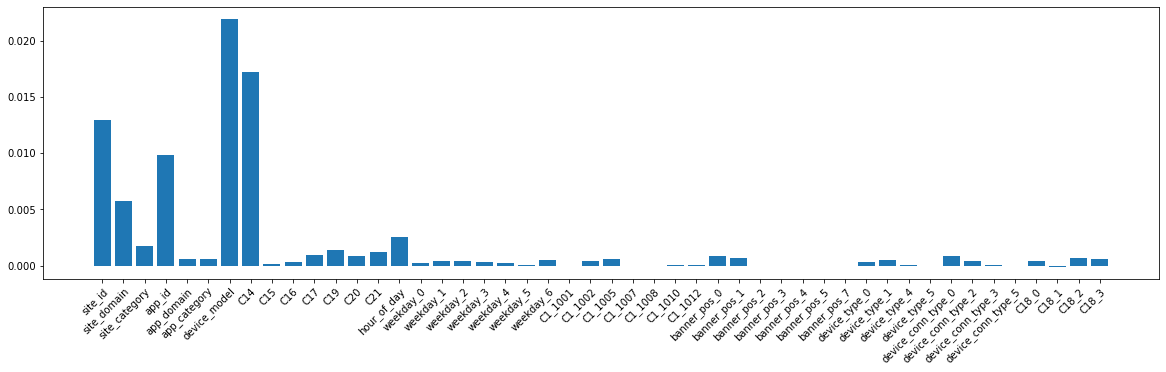

In [73]:
fi = perm.importances_mean
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(range(len(fi)), fi, align="center")
ax.set(xticks=range(len(fi)), xticklabels=X_train.columns)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

One important feature being C14, we could not take much interpretability from it.

From the features that we can interpret device model has the most relevant importance. A possible intuition could be the difference between softwares from each device, since newer versions could lead to better performance of the adds or some random explanation that this model is capturing.

Also, site id is explaining well the model. This could indicate that sites are build to atract the users to click on the add. It is a good metric to work on.

Finally, app id stands for another important feature.

One that could have a higher importance is hour of the day, since it could lead to different user responses. Clearly, is not explaining that much the model.

# Test Best Model

In [74]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(best_model)

Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('transformer',
                 TargetEncoder(cols=['site_id', 'site_domain', 'app_id',
                                     'device_model', 'C14', 'C17', 'C20'])),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=58,
                                        min_samples_leaf=37,
                                        min_samples_split=13, n_estimators=750,
                                        random_state=42))])


In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.60      0.72     16567
           1       0.27      0.73      0.40      3433

    accuracy                           0.62     20000
   macro avg       0.59      0.67      0.56     20000
weighted avg       0.81      0.62      0.67     20000



#### Confusion matrix
The predicted classes are represented in the columns of the matrix, whereas the actual classes are in the rows of the matrix. We then have four cases:
- True positives (TP): the cases for which the classifier predicted that a user clicks and the the class is actually that the user clicked.
- True negatives (TN): the cases for which the classifier predicted that the user will not click and the class is actually that it will not click.
- False positives (FP): the cases for which the classifier predicted that a user clicks but class is actually that it will not click.
- False negatives (FN): the cases for which the classifier predicted that the user will not click but the class is actually that the user clicked.


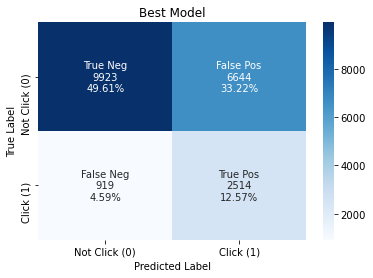

In [76]:
cf_matrix = confusion_matrix(y_test, y_pred)

# Names, counts and Percentage
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

# Join the above into text
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
categories = ['Not Click (0)','Click (1)']
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',xticklabels=categories,yticklabels=categories)
plt.title('Best Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Let's interpret these values:
Out of the 3433 instances of class 1 in our test set, the model identified 2512 of them as 1, and 921 predicted as 0 (false negatives, type II error).
Out of 16567 users of class 0, 9939 were identified correctly as 0, and 6628 were false positives (type I error).

Our main target was to sustain a high f1 score, since our dataset is imbalanced. Also, it is more relevant to the business model, to guarantee a good harmonic mean between recall and precision. The first one, to ensure that we increase our target prediction, in order to minimize failures and take out predictions of not clicking. The second one, to ensure that when it predicts the right class it does not fail that much.

As we see prediction is not beeing perfected by the model, but recall has a significant value. This leads to a good f1 score.

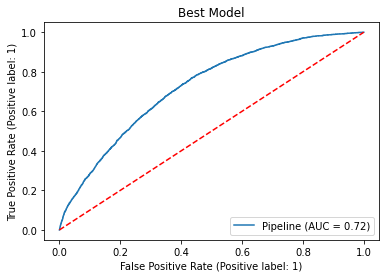

In [77]:
plot_roc_curve(best_model, X_test, y_test) 
plt.plot([0, 1], [0, 1],'r--')
plt.title('Best Model')

plt.show()

# Interpretability

In [78]:
# Imports
from sklearn.inspection import permutation_importance
import shap

## SHAP (SHapley Additive exPlanations)
The Shapley value is the average contribution of a feature value to the prediction in different coalitions. Shapley values are a robust mechanism to assess the importance of each feature to reach an output, and hence form a better alternative to standard feature importance mechanisms. 
These include the *TreeExplainer* which is optimized for tree-based models, *DeepExplainer* and *GradientExplainer* for neural networks, and *KernelExplainer*, which makes no assumptions about the underlying model to be explained. 

Given our best model is an Pipeline with an optimized `Random Forest Classifier` we will use *KernelExplainer*

In [79]:
row = 23
data_for_prediction = X_test.iloc[row]   
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=X_train.columns.to_list())
    return best_model.predict_proba(data_asframe)

explainer = shap.KernelExplainer(model_predict, X_test.iloc[0:100], link='logit')
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

**You can visualize feature attributions such as Shapley values as "forces". Each feature value is a force that either increases or decreases the prediction.* The prediction starts from the baseline. The baseline for Shapley values is the average of all predictions.** In the plot, each Shapley value is an arrow that pushes to increase (positive value) or decrease (negative value) the prediction. These forces balance each other out at the actual prediction of the data instance.

The output prediction is 1, which means the model classifies this observation as benign. The base value is 0.6321. Feature values that push towards a malignant tumor causing are in blue, and **the length of the region shows how much the feature contributes to this effect.** Feature values decreasing the prediction and making our tumor benign are in pink. If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.

To get an overview of which features are most important for a model on a global level, we can plot the SHAP values of every feature for every sample. 

### The idea behind SHAP feature importance is simple: Features with large absolute Shapley values are important.

In [80]:
random_sample = X_test.sample(200, random_state=42)
shap_values = explainer.shap_values(random_sample)

  0%|          | 0/200 [00:00<?, ?it/s]

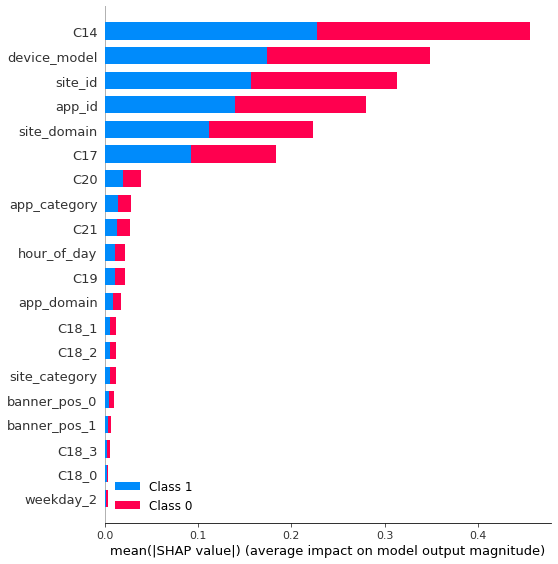

In [81]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

We can also plot the *summary_plot* for each feature and an instance.

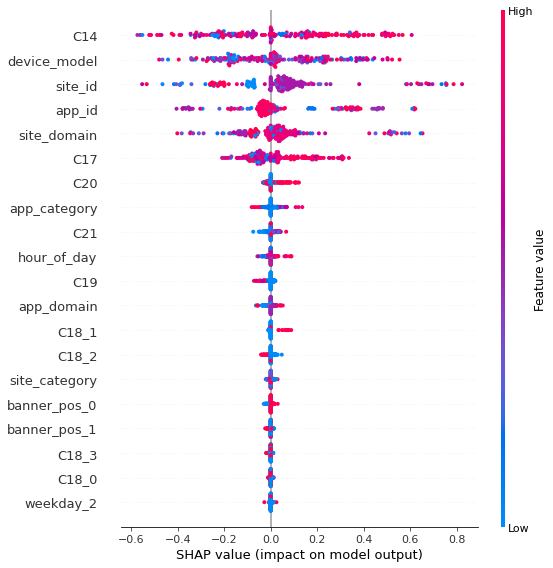

In [82]:
shap.summary_plot(shap_values[0], random_sample , plot_type='dot')

Each point on the summary plot is a Shapley value for a feature and an instance. 
- The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. 
- The color represents the value of the feature from low to high. 
-  Variables are ranked in descending order.
- The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
-  Color shows whether that variable is high (in red) or low (in blue) for that observation.
-  A low value of the *worst_area*  has a positive impact on the probability of the tumor being benign. The "low" comes from the blue color, and the "positive" impact is shown on the X-axis. Similarly,  a high value of the *worst_area*  has a large and negative impact on the probability of the tumor being benign.

#### Like many other methods above, Shapley values might end up being incorrectly estimated when features are correlated or interact with one another.

# Lime

In [83]:
row = 1300
data_for_prediction = X_train.iloc[row]   
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=X_train.columns.to_list())
    return best_model.predict_proba(data_asframe)

import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, 
                                                   verbose=True,
                                                   discretize_continuous=True)
exp = explainer.explain_instance(X_test.iloc[row, :], predict_fn=model_predict,
                                 num_samples=100, num_features=5)

Intercept 0.4247563367416159
Prediction_local [0.5344975]
Right: 0.7002150193372921


In [84]:
exp.show_in_notebook(show_table = True, show_all= False)

Features in orange support class 1 and those in blue support class 0. Float point numbers on the horizontal bars represent the relative importance of these features.

LIME helps on explaining how a new user's class was predicted and what where the main features that helped on it.

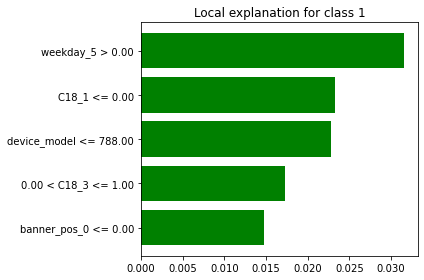

In [85]:
exp.as_pyplot_figure()
from matplotlib import pyplot as plt
plt.tight_layout()

In [86]:
from pdpbox import pdp

In [87]:
best_model

Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('transformer',
                 TargetEncoder(cols=['site_id', 'site_domain', 'app_id',
                                     'device_model', 'C14', 'C17', 'C20'])),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=58,
                                        min_samples_leaf=37,
                                        min_samples_split=13, n_estimators=750,
                                        random_state=42))])

In [88]:
X_test.columns

Index(['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain',
       'app_category', 'device_model', 'C14', 'C15', 'C16', 'C17', 'C19',
       'C20', 'C21', 'hour_of_day', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'C1_1001',
       'C1_1002', 'C1_1005', 'C1_1007', 'C1_1008', 'C1_1010', 'C1_1012',
       'banner_pos_0', 'banner_pos_1', 'banner_pos_2', 'banner_pos_3',
       'banner_pos_4', 'banner_pos_5', 'banner_pos_7', 'device_type_0',
       'device_type_1', 'device_type_4', 'device_type_5', 'device_conn_type_0',
       'device_conn_type_2', 'device_conn_type_3', 'device_conn_type_5',
       'C18_0', 'C18_1', 'C18_2', 'C18_3'],
      dtype='object')

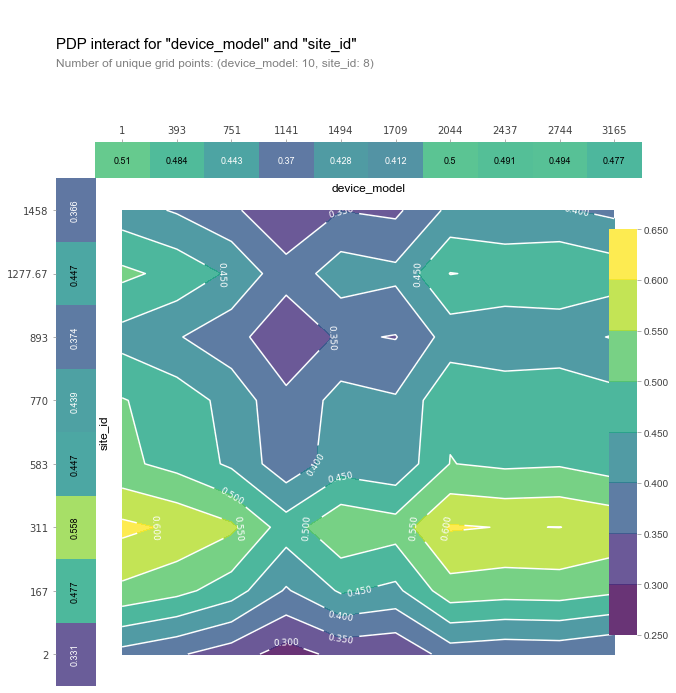

In [89]:
features_to_plot = ['device_model', 'site_id']

inter1  =  pdp.pdp_interact(model=best_model, dataset=X_test, model_features=X_test.columns, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour', x_quantile=True, plot_pdp=True)
plt.show()